1. 导入库

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

2. 定义ODE模型（确定性模拟）

In [35]:
def ode_system(t, y, k1, k2):

    E, S, C, P = y

    dEdt = -k1*E*S + k2*C

    dSdt = -k1*E*S

    dCdt = k1*E*S - k2*C

    dPdt = k2*C
    return [dEdt, dSdt, dCdt, dPdt]



# 参数设置


k1 = 0.001


k2 = 0.5
y0_ode = [100, 1000, 0, 0]  # [E（酶）, S（底物）, C（复合物）, P（产物）]
t_span = (0, 100)
t_eval = np.linspace(0, 100, 500)




# 解 ODE

sol = solve_ivp(ode_system, t_span, y0_ode, args=(k1, k2), t_eval=t_eval, method='RK45')

t_ode = sol.t

S_ode = sol.y[1]  # S(t) 的确定性解

3. 实现 Gillespie 算法（随机模拟）

In [36]:
def gillespie_step(state, t, k1, k2):

    E, S, C, P = state

    

    # 反应速率（propensity）

    a1 = k1 * E * S      # E + S → C

    a2 = k2 * C          # C → E + P

    a0 = a1 + a2         # 总速率

    
    if a0 == 0:
        return state, np.inf  # 结束

    

    # 时间增量
    tau = np.random.exponential(1 / a0)

    

    # 选择哪个反应发生

    r = np.random.rand()
    if r < a1 / a0:
        # 反应1发生：E + S → C
        new_state = [E-1, S-1, C+1, P]
    else:
        # 反应2发生：C → E + P
        new_state = [E+1, S, C-1, P+1]

    
    return new_state, tau

4. 运行单次 Gillespie 模拟

In [37]:
def simulate_gillespie(k1, k2, initial_state, max_time):
    state = np.array(initial_state)  # [E, S, C, P]

    t = 0.0
    trajectory = {'t': [t], 'E': [state[0]], 'S': [state[1]], 'C': [state[2]], 'P': [state[3]]}

    
    while t < max_time:
        new_state, tau = gillespie_step(state, t, k1, k2)
        if tau == np.inf:
            break
        t += tau
        state = np.array(new_state)
        
        # 记录状态
        trajectory['t'].append(t)
        trajectory['E'].append(state[0])
        trajectory['S'].append(state[1])
        trajectory['C'].append(state[2])
        trajectory['P'].append(state[3])

    
    return trajectory

5. 运行 500 次模拟并保存 S(t)

In [38]:
initial_state = [100, 1000, 0, 0]
max_time = 100

n_simulations = 500




# 共同时间网格用于插值
common_t = np.linspace(0, 100, 500)

all_S = []





# 存储10条代表轨迹用于绘图
representative_trajectories = []




for i in range(n_simulations):
    traj = simulate_gillespie(k1, k2, initial_state, max_time)

    t_traj = np.array(traj['t'])

    S_traj = np.array(traj['S'])

    

    # 插值到共同时间网格

    S_interp = np.interp(common_t, t_traj, S_traj)
    all_S.append(S_interp)

    

    # 保存前10条轨迹用于可视化
    if i < 10:
        representative_trajectories.append((t_traj, S_traj))

    
    if (i+1) % 50 == 0:
        print(f"已完成 {i+1} 次模拟")




# 计算平均 S(t)

mean_S = np.mean(all_S, axis=0)

std_S = np.std(all_S, axis=0)

已完成 50 次模拟
已完成 100 次模拟
已完成 150 次模拟
已完成 200 次模拟
已完成 250 次模拟
已完成 300 次模拟
已完成 350 次模拟
已完成 400 次模拟
已完成 450 次模拟
已完成 500 次模拟


6. 画图

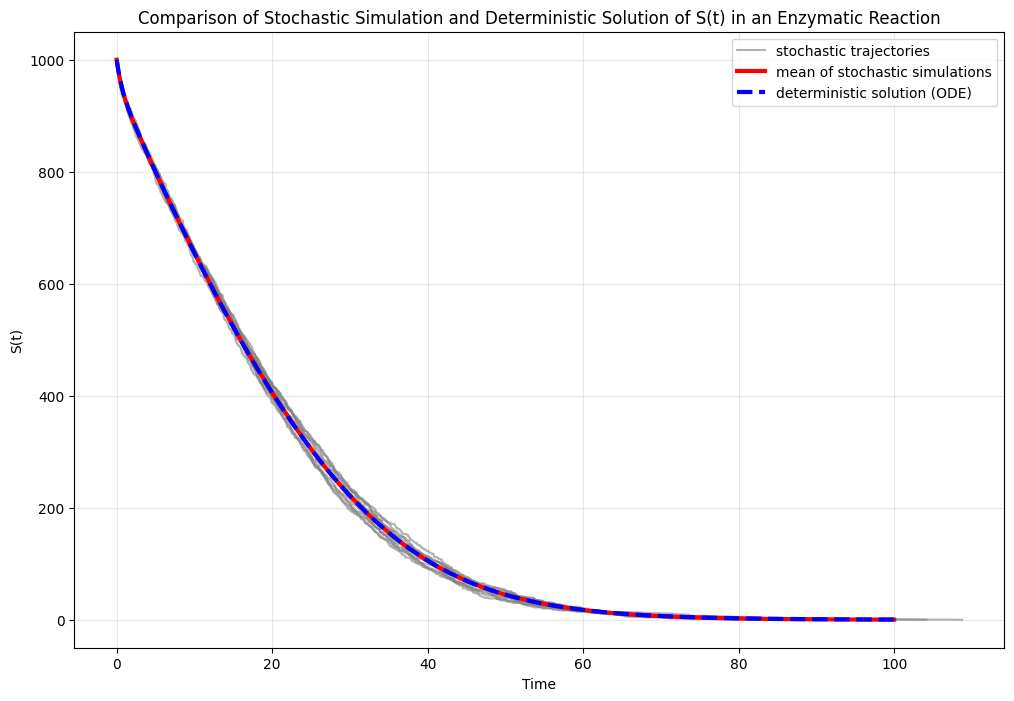

In [39]:
plt.figure(figsize=(12, 8))




# 1. 绘制10条代表性随机轨迹

for i, (t_traj, S_traj) in enumerate(representative_trajectories):
    plt.plot(t_traj, S_traj, color='gray', alpha=0.6, label=None if i > 0 else "stochastic trajectories")




# 2. 绘制随机模拟的平均值
plt.plot(common_t, mean_S, color='red', linewidth=3, label="mean of stochastic simulations")




# 3. 绘制 ODE 解
plt.plot(t_ode, S_ode, color='blue', linewidth=3, linestyle='--', label="deterministic solution (ODE)")




# 图像设置
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.title("Comparison of Stochastic Simulation and Deterministic Solution of S(t) in an Enzymatic Reaction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

7. 结果分析

随机模拟的平均行为与 ODE 确定性解基本一致。这说明在系统规模较大（分子数较多）时，随机涨落的平均效果趋近于确定性模型的预测，符合大数定律和化学主方程与ODE的对应关系。

尽管单个轨迹存在明显波动（体现生物系统内在噪声），但大量重复实验的平均结果收敛到 ODE 解，验证了两种建模方法的一致性。